In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import math
import re
import requests
from lxml import html
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud, STOPWORDS
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

movies_df = pd.read_csv('netflix.csv')
movies_df.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,genres,averageRating,numVotes,sortedTitle
0,tt1509787,movie,A Bag of Hammers,A Bag of Hammers,0,2011,\N,Comedy Drama,6.6,2833,A Bag of Hammers (2011)
1,tt5091612,movie,A Bag of Marbles,Un sac de billes,0,2017,\N,Drama War,7.3,4458,A Bag of Marbles (2017)
2,tt2064713,movie,A Band Called Death,A Band Called Death,0,2012,\N,Biography Documentary Music,7.5,3465,A Band Called Death (2012)
3,tt0067656,movie,A Bay of Blood,Ecologia del delitto,0,1971,\N,Horror Mystery Thriller,6.6,8850,A Bay of Blood (1971)
4,tt3224458,movie,A Beautiful Day in the Neighborhood,A Beautiful Day in the Neighborhood,0,2019,\N,Biography Drama,7.3,46668,A Beautiful Day in the Neighborhood (2019)


## Average Rating and Total Votes of the 20 most popular movies

In [2]:
top20_movies_df = movies_df.sort_values(by='numVotes', ascending=False)[:20]
fig = go.Figure(data=go.Scatter(x=top20_movies_df['numVotes'], y=top20_movies_df['averageRating'],
                                mode='markers+text', marker=dict(size=top20_movies_df['averageRating']**1.5, color=top20_movies_df['averageRating']),
                                text=top20_movies_df['originalTitle'], textposition='top center', textfont=dict(size=9),
                                customdata=top20_movies_df['genres'],
                                hoverlabel=dict(namelength=0),
                                hovertemplate='%{text}:<br>%{customdata}<br>%{x:.0f} votes<br>%{y:.1f} mean rating'))
fig.update_layout(title='Average Rating and Total Votes of the 20 most popular movies', template='plotly_white',
                  title_x=0.5, legend=dict(yanchor='bottom', y=-0.15, xanchor='left', x=0, font=dict(size=10), orientation='h'),
                  autosize=False, width=800, height=500)
fig['layout']['xaxis']['title'] = 'Total Votes'
fig['layout']['yaxis']['title'] = 'Average Rating'
fig.show()

## Average Rating and Total Votes colored by Genre for the the 100 most popular movies

In [3]:
top100_movies_df = movies_df.sort_values(by='numVotes', ascending=False)[:100]
fig = px.scatter(top100_movies_df, x='numVotes', y='averageRating', color='genres',
                 size='numVotes', hover_data=['originalTitle'])
fig.update_layout(title='Average Rating and Total Votes colored by Genre for the the 100 most popular movies', template='plotly_white',
                  title_x=0.5, legend=dict(yanchor='bottom', y=-0.15, xanchor='left', x=0, font=dict(size=10), orientation='h'),
                  autosize=False, width=1000, height=700)
fig['layout']['xaxis']['title'] = 'Total Votes'
fig['layout']['yaxis']['title'] = 'Average Rating'
fig.show()

## Movie release year decades for 100 most popular movies based on rating

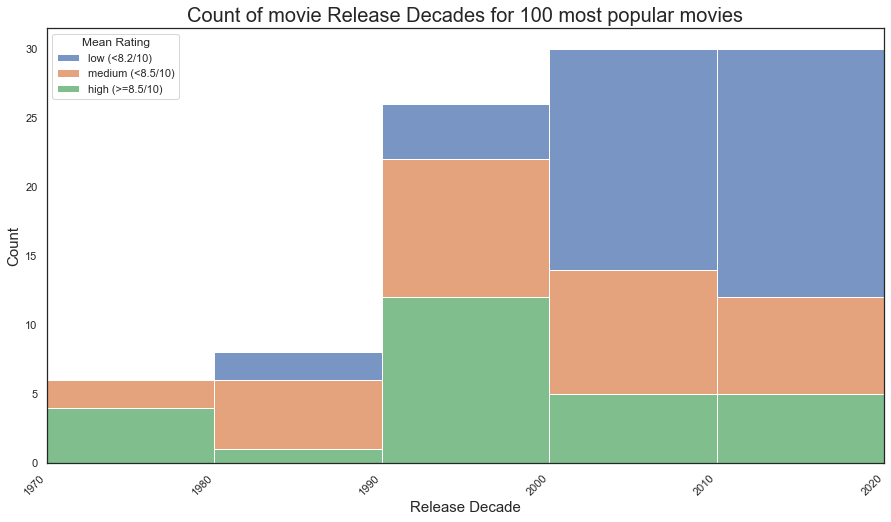

In [4]:
top100_movies_df['mean_rating_qcut'], qcut_mean_ratings = pd.qcut(x=top100_movies_df['averageRating'], q=3, retbins=True)
mean_rating_labels = ['low (<' + str(qcut_mean_ratings[1]) + '/10)',
                   'medium (<' + str(qcut_mean_ratings[2]) + '/10)',
                   'high (>=' + str(qcut_mean_ratings[2]) + '/10)']
top100_movies_df['mean_rating_qcut'] = pd.qcut(x=top100_movies_df['averageRating'], q=3, labels=mean_rating_labels)
top100_movies_df['decade'] = (top100_movies_df['startYear']//10)*10
n_bins = int(((top100_movies_df['decade'].max()-top100_movies_df['decade'].min())/10)+1)
sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Count of movie Release Decades for 100 most popular movies', size=20)
ax = sns.histplot(data=top100_movies_df.sort_values(by='mean_rating_qcut', ascending=True), x='decade', stat='count', hue='mean_rating_qcut', multiple='stack',
                  bins=n_bins, binrange=(top100_movies_df['decade'].min(), top100_movies_df['decade'].max()+10))
ax.margins(x=0)
ax.legend_.set_title('Mean Rating') 
plt.xlabel('Release Decade', size=15)
plt.ylabel('Count', size=15)
plt.xticks(np.arange(top100_movies_df['decade'].min(), top100_movies_df['decade'].max()+20, step=10), rotation=45, ha='right')
plt.show()

## Count of movie genres 

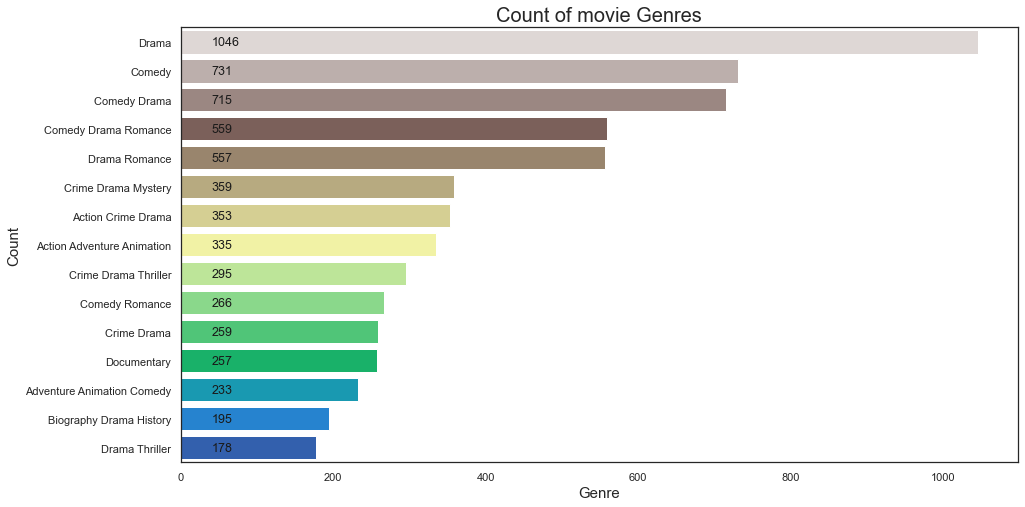

In [5]:
sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Count of movie Genres', size=20)
top15_genres = movies_df['genres'].value_counts()[:15]
ax = sns.barplot(x=top15_genres.values, y=top15_genres.index, palette='terrain_r')
plt.xlabel('Genre', size=15)
plt.ylabel('Count', size=15)
for i, v in enumerate(top15_genres.values):
    plt.text(x=40, y=i+0.12, s=v, color='k', fontsize=12.5)
plt.show()

## Count of different types of title 

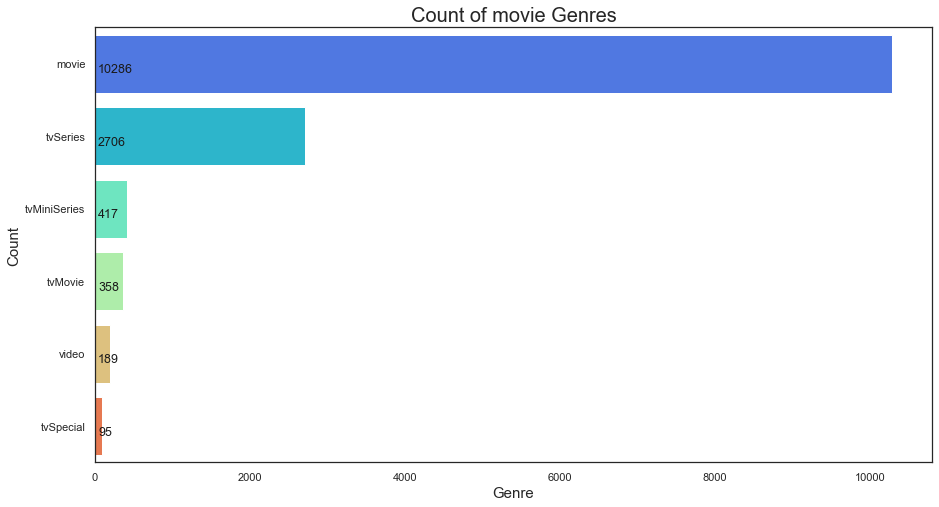

In [6]:
sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Count of movie Genres', size=20)
top15_genres = movies_df['titleType'].value_counts()[:15]
ax = sns.barplot(x=top15_genres.values, y=top15_genres.index, palette='rainbow')
plt.xlabel('Genre', size=15)
plt.ylabel('Count', size=15)
for i, v in enumerate(top15_genres.values):
    plt.text(x=40, y=i+0.12, s=v, color='k', fontsize=12.5)
plt.show()

## Count of movie Release Years, including the Genres sub-counts

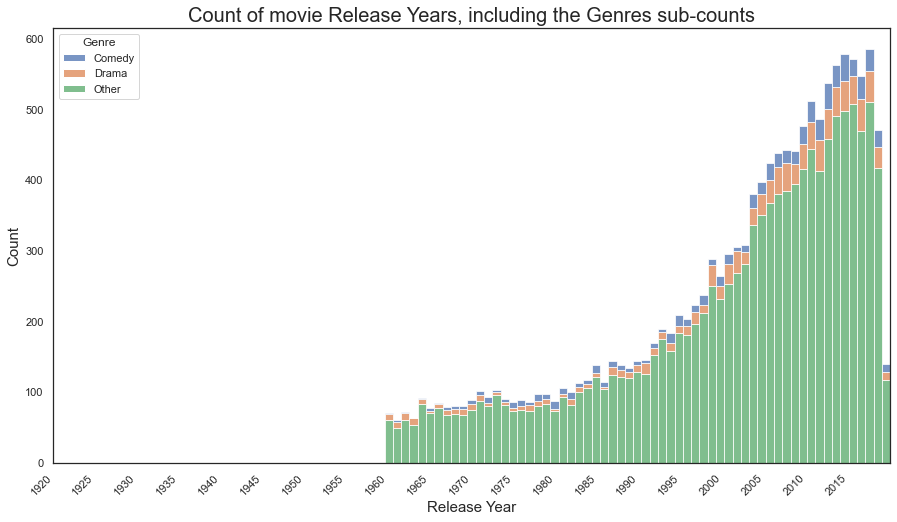

In [7]:
sns.set(style='white')
top2_genres = movies_df['genres'].value_counts()[:2]
movies_df['generic_genre'] = [x if x in top2_genres.index.tolist() else 'Other' for x in movies_df['genres']]
min_year = 1920
max_year = max(movies_df['startYear'])
plt.figure(figsize=(15, 8))
plt.title('Count of movie Release Years, including the Genres sub-counts', size=20)
ax = sns.histplot(data=movies_df.sort_values(by='generic_genre', ascending=True), x='startYear', stat='count', bins=max_year-min_year+1, # each release year has its own bin
                  binrange=(min_year, max_year), hue='generic_genre', multiple='stack')
ax.legend_.set_title('Genre') # setting only the legend title, without specifying the labels (somehow seaborn kept inverting the labels order in the usual legend setup)
ax.margins(x=0)
plt.xlabel('Release Year', size=15)
plt.ylabel('Count', size=15)
plt.xticks(np.arange(min_year, max_year, step=5), rotation=45, ha='right')
plt.show()

## Relative density of movies release year based on the genre

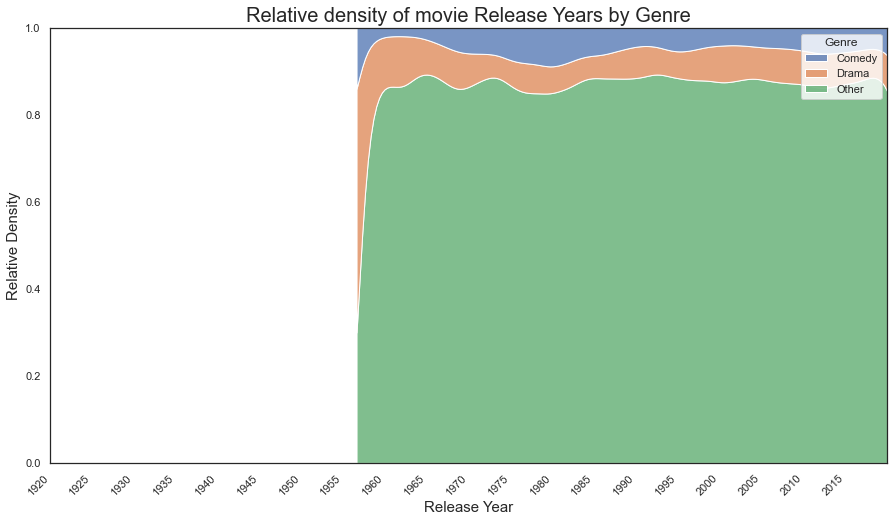

In [8]:
# sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Relative density of movie Release Years by Genre', size=20)
ax = sns.kdeplot(data=movies_df[movies_df['startYear'].astype('Int32') >= min_year].sort_values(by='generic_genre', ascending=True),
                 x='startYear', hue='generic_genre', bw_adjust=.5, multiple='fill')
ax.legend_.set_title('Genre') 
ax.margins(x=-0.05) 
plt.xlabel('Release Year', size=15)
plt.ylabel('Relative Density', size=15)
plt.xticks(np.arange(min_year, max_year, step=5), rotation=45, ha='right')
plt.show()


## Relative density of release year based on the title type

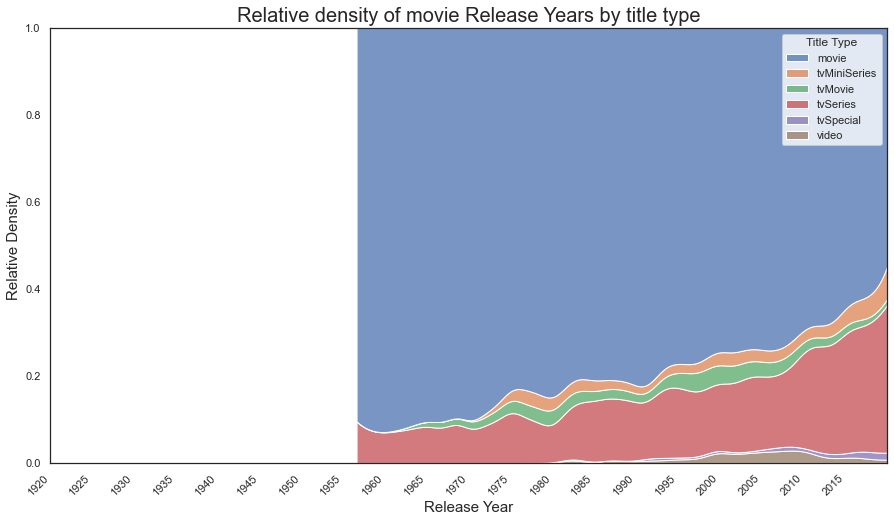

In [15]:
# sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Relative density of movie Release Years by title type', size=20)
ax = sns.kdeplot(data=movies_df[movies_df['startYear'].astype('Int32') >= min_year].sort_values(by='titleType', ascending=True),
                 x='startYear', hue='titleType', bw_adjust=.5, multiple='fill')
ax.legend_.set_title('Title Type') 
ax.margins(x=-0.05) 
plt.xlabel('Release Year', size=15)
plt.ylabel('Relative Density', size=15)
plt.xticks(np.arange(min_year, max_year, step=5), rotation=45, ha='right')
plt.show()


## Dispersion of average ratings based on the genre

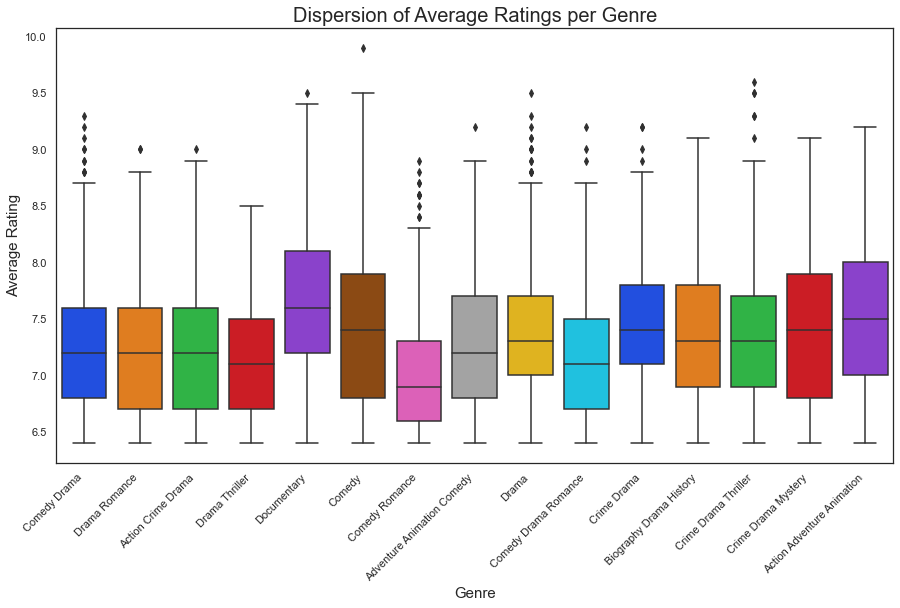

In [9]:
sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Dispersion of Average Ratings per Genre', fontsize=20)
ax = sns.boxplot(data=movies_df[movies_df['genres'].isin(movies_df['genres'].value_counts()[:15].index.tolist())], # filtering only the movies with top15 genres
                 x='genres', y='averageRating', palette='bright')
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.show()

## Crosstab with the correlations between Title Type and average Rating

In [10]:
movie_genres_crosstab = pd.crosstab(
    movies_df[movies_df['titleType'].isin(movies_df['titleType'].value_counts()[:15].index.tolist())]['titleType'], 
    movies_df[movies_df['titleType'].isin(movies_df['titleType'].value_counts()[:15].index.tolist())]['averageRating'])
movie_genres_crosstab.style.background_gradient(cmap='magma')

averageRating,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9
titleType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
movie,699,665,684,704,681,632,630,703,708,651,573,509,508,391,325,261,257,207,137,112,72,55,43,25,20,13,12,5,2,2,0,0,0,0,0,0
tvMiniSeries,5,5,11,7,8,9,9,17,16,18,24,12,21,21,20,21,26,27,18,19,16,24,17,8,6,5,9,7,3,3,3,2,0,0,0,0
tvMovie,17,21,18,19,19,15,27,29,29,18,19,20,14,13,11,17,13,12,11,8,3,2,0,2,0,1,0,0,0,0,0,0,0,0,0,0
tvSeries,37,57,69,68,82,80,99,100,136,132,137,173,135,127,127,139,129,155,142,129,110,94,76,59,41,23,12,12,11,6,2,3,1,1,1,1
tvSpecial,0,3,2,2,1,0,1,2,2,5,5,5,6,6,3,7,8,3,5,7,6,5,6,2,2,0,0,0,0,1,0,0,0,0,0,0
video,12,9,12,12,9,5,12,15,9,15,9,7,9,6,9,3,3,9,0,4,5,3,1,4,0,0,1,0,4,1,0,1,0,0,0,0


## Crosstab with the correlations between most common genres and average Rating

In [11]:
movie_genres_crosstab = pd.crosstab(
    movies_df[movies_df['genres'].isin(movies_df['genres'].value_counts()[:15].index.tolist())]['genres'], 
    movies_df[movies_df['genres'].isin(movies_df['genres'].value_counts()[:15].index.tolist())]['averageRating'])
movie_genres_crosstab.style.background_gradient(cmap='summer_r')

averageRating,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.9
genres,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Action Adventure Animation,5,8,14,13,19,9,20,21,20,20,9,15,14,13,24,17,19,15,7,10,11,14,5,6,2,2,1,1,1,0,0,0,0,0
Action Crime Drama,30,22,21,20,23,14,19,23,17,27,22,13,19,14,12,8,10,8,8,5,7,5,2,1,1,1,1,0,0,0,0,0,0,0
Adventure Animation Comedy,17,10,13,18,18,14,6,13,18,17,7,8,12,11,11,10,6,7,5,6,1,0,1,2,0,1,0,0,1,0,0,0,0,0
Biography Drama History,5,6,17,9,8,7,7,15,15,18,7,17,3,10,12,6,4,7,5,5,2,4,0,1,0,2,2,1,0,0,0,0,0,0
Comedy,47,38,44,33,31,36,38,33,29,31,39,30,35,34,27,29,25,27,21,22,21,18,15,10,6,4,2,3,1,0,0,1,0,1
Comedy Drama,33,39,45,44,40,32,36,35,54,57,52,43,35,22,22,26,20,17,14,12,10,9,3,5,3,2,2,1,1,1,0,0,0,0
Comedy Drama Romance,39,34,33,49,52,25,44,39,37,30,34,31,22,22,5,11,10,11,7,9,4,1,6,1,0,1,1,0,1,0,0,0,0,0
Comedy Romance,28,35,26,16,23,18,19,16,12,10,6,8,7,6,4,3,5,7,1,5,2,1,4,2,1,1,0,0,0,0,0,0,0,0
Crime Drama,8,7,6,10,13,9,10,25,20,16,24,20,15,10,6,7,10,8,7,7,6,4,4,2,1,1,1,0,2,0,0,0,0,0


## Estimations of average Rating based on release year and broken down by genre name

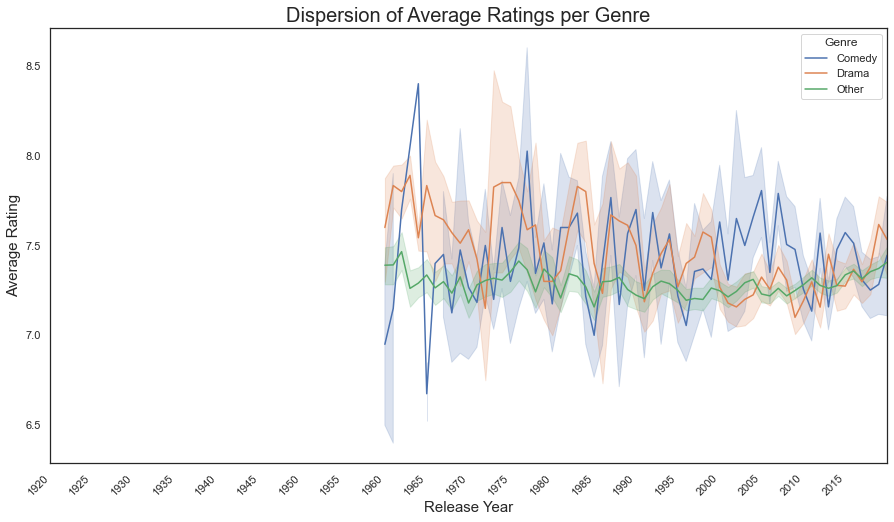

In [12]:

sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Dispersion of Average Ratings per Genre', fontsize=20)
ax = sns.lineplot(data=movies_df[movies_df['startYear'].astype('Int32') >= min_year].sort_values(by='generic_genre', ascending=True), x='startYear', y='averageRating',
                  ci=85, hue='generic_genre') 
ax.legend_.set_title('Genre') 
ax.margins(x=0)
plt.xlabel('Release Year', fontsize=15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(np.arange(min_year, max_year, step=5), rotation=45, ha='right')
plt.show()

## Showing famous keywords for most popular genre 

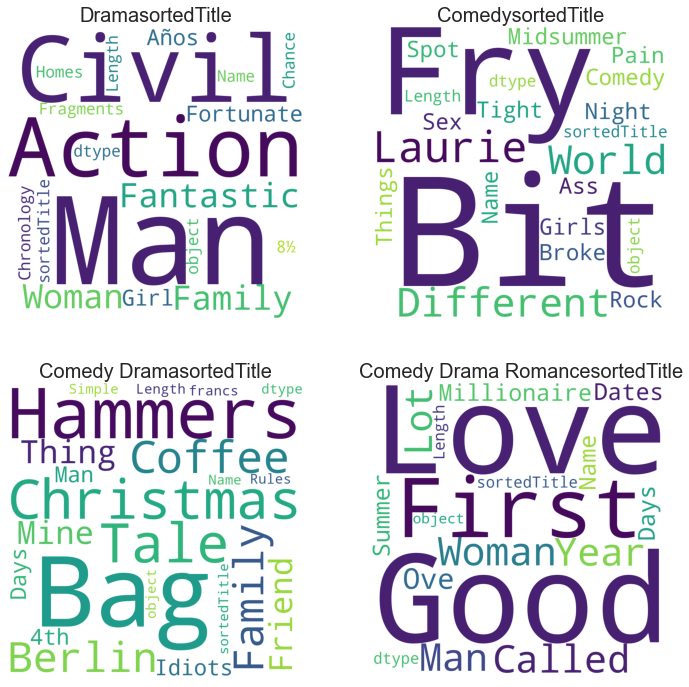

In [13]:
top4_genres = movies_df['genres'].value_counts()[:4]

fig = plt.figure(figsize=(12, 12), facecolor=None)
for i in range(len(top4_genres)):
    ax = fig.add_subplot(2, 2, i+1)
    subset = movies_df[movies_df['genres'] == top4_genres.index[i]]['sortedTitle']
    plt.title(top4_genres.index[i] + 'sortedTitle', fontsize=20)
    ax.imshow(WordCloud(width=1000, height=1000, background_color='white', stopwords=set(STOPWORDS),
                        max_words=200, min_font_size=20, random_state=42).generate(str(subset)))
    ax.axis('off')